## Global settings and imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Dict, List, Optional
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings, generate_embeddings_with_transformers
from utils._python import write_submission_file, rank_predictions_by_score
from models_pytorch.model_config import hparams_nrms

from models_pytorch.nrms import NRMSModel
from models_pytorch.NRMSDocVecModel import NRMSDocVecModel

from transformers import AutoModel, AutoTokenizer
from models_pytorch.dataloader import NRMSDataLoader



# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.1
PyTorch version: 2.5.1+cu121
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3070
Number of GPUs available: 1


## Prepare parameters

In [2]:
seed = 42
batch_size = 32

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

## Download and load data

In [3]:
PATH = Path("./ebnerd_small")  # Base path for your data directory
print(PATH)


ebnerd_small


In [4]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
]
HISTORY_SIZE = 10 # TODO: History size. 
FRACTION = 0.05

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

shape: (2, 6)
┌─────────┬───────────────────┬───────────────────┬──────────────────┬───────────────┬─────────────┐
│ user_id ┆ article_id_fixed  ┆ article_ids_invie ┆ article_ids_clic ┆ impression_id ┆ labels      │
│ ---     ┆ ---               ┆ w                 ┆ ked              ┆ ---           ┆ ---         │
│ u32     ┆ list[i32]         ┆ ---               ┆ ---              ┆ u32           ┆ list[i8]    │
│         ┆                   ┆ list[i64]         ┆ list[i64]        ┆               ┆             │
╞═════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════╪═════════════╡
│ 1022897 ┆ [9770551,         ┆ [9769917,         ┆ [9770102]        ┆ 555487580     ┆ [0, 1, … 0] │
│         ┆ 9767546, …        ┆ 9770102, …        ┆                  ┆               ┆             │
│         ┆ 9770989]          ┆ 9773137]          ┆                  ┆               ┆             │
│ 1289547 ┆ [9768002,         ┆ [9778219,         ┆ [9778722]        ┆ 293534111     ┆ [0, 0, … 0] │
│         ┆ 9766721, …        ┆ 9777397, …        ┆                  ┆               ┆             │
│         ┆ 9769893]          ┆ 9778219]          ┆                  ┆               ┆             │
└─────────┴───────────────────┴───────────────────┴──────────────────┴───────────────┴─────────────┘

In [5]:
import polars as pl

# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 90
Longest history length in df_train: 10
Longest history length in df_validation: 10


In [6]:
import polars as pl

# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 11713
Number of rows with exactly one clicked article in df_validation: 12176


In [7]:
df_validation.head()
# number of users


shape: (5, 6)
┌─────────┬───────────────────┬───────────────────┬──────────────────┬───────────────┬─────────────┐
│ user_id ┆ article_id_fixed  ┆ article_ids_invie ┆ article_ids_clic ┆ impression_id ┆ labels      │
│ ---     ┆ ---               ┆ w                 ┆ ked              ┆ ---           ┆ ---         │
│ i64     ┆ list[i64]         ┆ ---               ┆ ---              ┆ i64           ┆ list[i64]   │
│         ┆                   ┆ list[i64]         ┆ list[i64]        ┆               ┆             │
╞═════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════╪═════════════╡
│ 1998759 ┆ [9780019,         ┆ [9789386,         ┆ [9788024]        ┆ 479058116     ┆ [0, 0, … 1] │
│         ┆ 9779648, …        ┆ 9787722, …        ┆                  ┆               ┆             │
│         ┆ 9779430]          ┆ 9788024]          ┆                  ┆               ┆             │
│ 1383295 ┆ [9777822,         ┆ [9779427,         ┆ [9779417]        ┆ 349219117     ┆ [0, 0, … 0] │
│         ┆ 9779511, …        ┆ 9366571, …        ┆                  ┆               ┆             │
│         ┆ 9779517]          ┆ 9779564]          ┆                  ┆               ┆             │
│ 2419726 ┆ [9776190,         ┆ [9773727,         ┆ [9773727]        ┆ 119537592     ┆ [1, 0, … 0] │
│         ┆ 9777565, …        ┆ 9783164, …        ┆                  ┆               ┆             │
│         ┆ 9776337]          ┆ 9781360]          ┆                  ┆               ┆             │
│ 823326  ┆ [9778102,         ┆ [9786111,         ┆ [9785019]        ┆ 214086519     ┆ [0, 0, … 0] │
│         ┆ 9777750, …        ┆ 9784097, …        ┆                  ┆               ┆             │
│         ┆ 9778168]          ┆ 9782769]          ┆                  ┆               ┆             │
│ 806990  ┆ [9776223,         ┆ [9779650,         ┆ [9781502]        ┆ 386289507     ┆ [0, 0, … 1] │
│         ┆ 9778971, …        ┆ 9532638, …        ┆                  ┆               ┆             │
│         ┆ 9780181]          ┆ 9781502]          ┆                  ┆               ┆             │
└─────────┴───────────────────┴───────────────────┴──────────────────┴───────────────┴─────────────┘

In [8]:
print(f"Number of users in df_train: {df_train['user_id'].n_unique()}")

Number of users in df_train: 6343


In [9]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(10)

shape: (10, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ article_i ┆ title     ┆ subtitle  ┆ last_modi ┆ … ┆ total_pag ┆ total_rea ┆ sentiment ┆ sentimen │
│ d         ┆ ---       ┆ ---       ┆ fied_time ┆   ┆ eviews    ┆ d_time    ┆ _score    ┆ t_label  │
│ ---       ┆ str       ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i32       ┆           ┆           ┆ datetime[ ┆   ┆ i32       ┆ f32       ┆ f32       ┆ str      │
│           ┆           ┆           ┆ μs]       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 3001353   ┆ Natascha  ┆ Politiet  ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9955    ┆ Negative │
│           ┆ var ikke  ┆ frygter   ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ den       ┆ nu, at    ┆ 06:20:33  ┆   ┆           ┆           ┆           ┆          │
│           ┆ første    ┆ Natasc…   ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3003065   ┆ Kun Star  ┆ Biografgæ ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.846     ┆ Positive │
│           ┆ Wars      ┆ ngerne    ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ tjente    ┆ strømmer  ┆ 06:20:35  ┆   ┆           ┆           ┆           ┆          │
│           ┆ mere      ┆ ind f…    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3012771   ┆ Morten    ┆ FODBOLD:  ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.8241    ┆ Negative │
│           ┆ Bruun     ┆ Morten    ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ fyret i   ┆ Bruun     ┆ 06:20:39  ┆   ┆           ┆           ┆           ┆          │
│           ┆ Sønderjys ┆ fyret me… ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3023463   ┆ Luderne   ┆ I landets ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.7053    ┆ Neutral  │
│           ┆ flytter   ┆ tyndest   ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ på landet ┆ befolkede ┆ 06:20:43  ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ om…       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3032577   ┆ Cybersex: ┆ En        ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9307    ┆ Neutral  │
│           ┆ Hvornår   ┆ flirtende ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ er man    ┆ sms til   ┆ 06:20:46  ┆   ┆           ┆           ┆           ┆          │
│           ┆ utro?     ┆ den       ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ flott…    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3033563   ┆ Kniven    ┆ I         ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9371    ┆ Neutral  │
│           ┆ for strub ┆ aftenens  ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ en-vært   ┆ udgave af ┆ 06:20:47  ┆   ┆           ┆           ┆           ┆          │
│           ┆ får se…   ┆ 'Med      ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ kniv…     ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3034608   ┆ Willy     ┆ Den       ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9971    ┆ Negative │
│           ┆ Strube    ┆ tidligere ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ har       ┆ SiD-chef  ┆ 06:20:49  ┆   ┆           ┆           ┆           ┆          │
│           ┆ begået    ┆ tog sit…  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ selvmo…   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3034849   ┆ Venner    ┆ VK-REGERI ┆ 2023-06

In [10]:
from transformers import AutoConfig, AutoTokenizer, AutoModel


In [11]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
#TRANSFORMER_MODEL_NAME = "prajjwal1/bert-tiny"
#TRANSFORMER_MODEL_NAME = "distilbert-base-multilingual-cased"

#TRANSFORMER_MODEL_NAME = "pbelcak/UltraFastBERT-1x11-long"

TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL] # DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

In [12]:
# # 1. Create custom tokenizer and config
# from transformers import AutoConfig, AutoTokenizer, AutoModel
# from torch.nn.utils.prune import l1_unstructured

# VOCAB_SIZE = 10000  # Reduced from 250k
# EMBEDDING_DIM = 128 # Reduced from 768

# # 2. Load with smaller config
# config = AutoConfig.from_pretrained(TRANSFORMER_MODEL_NAME)
# config.vocab_size = VOCAB_SIZE
# config.hidden_size = EMBEDDING_DIM
# config.num_attention_heads = 4
# config.intermediate_size = EMBEDDING_DIM * 4

# # 3. Initialize tokenizer with smaller vocab
# transformer_tokenizer = AutoTokenizer.from_pretrained(
#     TRANSFORMER_MODEL_NAME,
#     model_max_length=128,
#     vocab_size=VOCAB_SIZE
# )

# # 4. Load model with reduced config and ignore mismatched sizes
# transformer_model = AutoModel.from_pretrained(
#     TRANSFORMER_MODEL_NAME,
#     config=config,
#     ignore_mismatched_sizes=True  # Ignore size mismatches
# )

# # 5. Apply pruning to embedding layer (optional)
# l1_unstructured(
#     transformer_model.embeddings.word_embeddings,
#     name='weight',
#     amount=0.3  # Prune 30% of weights
# )

# word2vec_embedding = get_transformers_word_embeddings(transformer_model)

In [13]:
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

In [14]:
print(f"Number of articles: {len(article_mapping)}")
print(f"article_mapping: {article_mapping}")

Number of articles: 20738
article_mapping: {3001353: shape: (30,)
Series: '' [i64]
[
	149746
	170931
	56
	315
	4
	…
	472
	14936
	62226
	3491
	89923
], 3003065: shape: (30,)
Series: '' [i64]
[
	1843
	34815
	177
	3405
	12060
	…
	182
	54201
	10266
	168
	100
], 3012771: shape: (30,)
Series: '' [i64]
[
	44944
	397
	98335
	397
	12
	…
	126
	17
	140069
	170
	74494
], 3023463: shape: (30,)
Series: '' [i64]
[
	87
	88192
	2281
	1067
	271
	…
	8409
	8675
	133
	4227
	4
], 3032577: shape: (30,)
Series: '' [i64]
[
	357
	105271
	2285
	22515
	139
	…
	987
	5
	357
	1740
	9
], 3033563: shape: (30,)
Series: '' [i64]
[
	87
	46466
	1755
	143557
	261
	…
	1823
	545
	139
	99
	5015
], 3034608: shape: (30,)
Series: '' [i64]
[
	1575
	12532
	602
	397
	9
	…
	17514
	66
	115514
	42
	20255
], 3034849: shape: (30,)
Series: '' [i64]
[
	310
	605
	9
	11766
	56599
	…
	1
	1
	1
	1
	1
], 3035648: shape: (30,)
Series: '' [i64]
[
	4699
	86
	44767
	1015
	95815
	…
	1
	1
	1
	1
	1
], 3036444: shape: (30,)
Series: '' [i64]
[
	10453
	2

In [15]:
print(f"word embeddings shape: {word2vec_embedding.shape}")

word embeddings shape: (250002, 768)


# Init dataloaders



In [16]:


train_dataset = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=2*batch_size,
)
val_dataset = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=batch_size,
)

In [17]:
for idx in range(5):
    sample = train_dataset[idx]
    print(f"Sample {idx}:")
    print(f"his_input_title shape: {sample[0][0].shape}")
    print(f"pred_input_title shape: {sample[0][1].shape} {sample[0][1].sum()}")
    print(f"Targets shape: {sample[1].shape} , {sample[1].dtype} {sample[1].sum()}")


Sample 0:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 4070555.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 1:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 2951239.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 2:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 3404477.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 3:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 3892311.0
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 4:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30]) 1899878.0
Targets shape: torch.Size([5]) , torch.float32 1.0


In [18]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    try:
        his_input_titles = [item[0][0] for item in batch]  # List of tensors
        pred_input_titles = [item[0][1] for item in batch]
        batch_ys = [item[1] for item in batch]

        # Check for empty sequences
        for idx, seq in enumerate(his_input_titles):
            if seq.size(0) == 0:
                print(f"Empty his_input_title at batch index {idx}")
        for idx, seq in enumerate(pred_input_titles):
            if seq.size(0) == 0:
                print(f"Empty pred_input_title at batch index {idx}")
        for idx, seq in enumerate(batch_ys):
            if seq.size(0) == 0:
                print(f"Empty batch_y at batch index {idx}")

        # Remove empty sequences or handle them appropriately
        # For now, let's filter them out
        valid_indices = [i for i, seq in enumerate(his_input_titles) if seq.size(0) > 0 and pred_input_titles[i].size(0) > 0 and batch_ys[i].size(0) > 0]
        if not valid_indices:
            raise ValueError("All sequences in the batch are empty.")

        his_input_titles = [his_input_titles[i] for i in valid_indices]
        pred_input_titles = [pred_input_titles[i] for i in valid_indices]
        batch_ys = [batch_ys[i] for i in valid_indices]

        # Pad sequences
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=0)

        return (his_input_titles_padded, pred_input_titles_padded), batch_ys_padded
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise

In [19]:
# Wrap the dataset with DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn

)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

## Create hyper-parameters

In [20]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    his_input_title, pred_input_title = inputs
    print(f"Batch {batch_idx + 1}")
    print(f"his_input_title shape: {his_input_title.shape}, dtype: {his_input_title.dtype}")
    print(f"pred_input_title shape: {pred_input_title.shape}, dtype: {pred_input_title.dtype}")
    print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
    break

Batch 1
his_input_title shape: torch.Size([32, 10, 30]), dtype: torch.float32
pred_input_title shape: torch.Size([32, 5, 30]), dtype: torch.float32
Targets shape: torch.Size([32, 5]), dtype: torch.float32


In [21]:
# hparams_nrms.attention_hidden_dim = 10
# hparams_nrms.head_num = 2
# hparams_nrms.head_dim = 2
# hparams_nrms.hidden_dim = 5
# hparams_nrms.news_output_dim = 100

print(hparams_nrms.__dict__)

{'__module__': 'models_pytorch.model_config', '__annotations__': {'title_size': <class 'int'>, 'history_size': <class 'int'>, 'embedding_dim': <class 'int'>, 'word_emb_dim': <class 'int'>, 'vocab_size': <class 'int'>, 'head_num': <class 'int'>, 'head_dim': <class 'int'>, 'attention_hidden_dim': <class 'int'>, 'optimizer': <class 'str'>, 'loss': <class 'str'>, 'dropout': <class 'float'>, 'learning_rate': <class 'float'>, 'units_per_layer': list[int]}, 'title_size': 30, 'history_size': 10, 'embedding_dim': 32, 'word_emb_dim': 8, 'vocab_size': 10000, 'head_num': 2, 'head_dim': 4, 'attention_hidden_dim': 4, 'hidden_dim': 4, 'optimizer': 'adam', 'loss': 'cross_entropy_loss', 'dropout': 0.3, 'learning_rate': 0.001, 'news_output_dim': 5, 'units_per_layer': [32, 32, 32], '__dict__': <attribute '__dict__' of 'hparams_nrms' objects>, '__weakref__': <attribute '__weakref__' of 'hparams_nrms' objects>, '__doc__': None}


## Train the NRMS model

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=2, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.verbose:
                print(f"Initial validation loss: {self.best_loss:.6f}")
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss decreased to {self.best_loss:.6f}. Resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
early_stopping = EarlyStopping(patience=2, verbose=True)
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)


# Initialize your model
# Ensure that NRMSModel is a PyTorch nn.Module

# CUDA checks
#print(f"CUDA Available: {torch.cuda.is_available()}")
#print(f"Current Device: {torch.cuda.current_device()}")
#print(f"Device Name: {torch.cuda.get_device_name()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
# model = NRMSModel(
#     hparams=hparams_nrms.__dict__,
#     word2vec_embedding=word2vec_embedding,
#     vocab_size=1000,
#     word_emb_dim=8,
#     seed=seed,
#     device=device
# )

model = NRMSDocVecModel(hparams=hparams_nrms.__dict__,
                        device=device)
print(f"Model device: {next(model.parameters()).device}")

Using device: cuda
Model device: cuda:0


c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\models_pytorch\NRMSDocVecModel.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()


In [23]:
def print_prediction_details(outputs, targets, k=5):
    """Print detailed prediction information for the first k samples"""
    # Get predicted class (highest score)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate accuracy for this batch
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = 100 * correct / total
    
    # Print details for k samples
    for i in range(min(k, len(targets))):
        print(f"\nSample {i}:")
        print(f"Predicted probabilities: {torch.softmax(outputs[i], dim=0)}")
        print(f"Predicted class: {predicted[i]}, True class: {targets[i]}")
        print(f"Correct: {predicted[i] == targets[i]}")
    
    return accuracy

In [24]:
# 1. Print model architecture
print(model)

# 2. Print specific layer sizes
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

# 3. Get total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# 4. Print layer by layer with shapes
def print_model_structure(model):
    print("\nDetailed Model Structure:")
    for name, module in model.named_children():
        print(f"\nLayer: {name}")
        print(f"Type: {type(module).__name__}")
        if hasattr(module, 'weight'):
            print(f"Shape: {module.weight.shape}")

NRMSDocVecModel(
  (newsencoder): NewsEncoderDocVec(
    (model): Sequential(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.3, inplace=False)
      (8): Linear(in_features=32, out_features=32, bias=True)
      (9): ReLU()
      (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.3, inplace=False)
      (12): Linear(in_features=32, out_features=5, bias=True)
      (13): ReLU()
    )
  )
  (userencoder): UserEncoderDocVec(
    (titleencoder): NewsEncoderDocVec(
      (model): Sequential(
        (0): Linear(in_features=30, out_features=32, bias=True)
        (1): ReLU()
       

In [25]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")

Layer: newsencoder.model.0.weight | Size: torch.Size([32, 30]) | Parameters: 960
Layer: newsencoder.model.0.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.2.weight | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.2.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.4.weight | Size: torch.Size([32, 32]) | Parameters: 1024
Layer: newsencoder.model.4.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.6.weight | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.6.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.8.weight | Size: torch.Size([32, 32]) | Parameters: 1024
Layer: newsencoder.model.8.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.10.weight | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.10.bias | Size: torch.Size([32]) | Parameters: 32
Layer: newsencoder.model.12.weight | Size: torch.Size([5, 32]) | Parameters: 160


In [26]:
from tqdm import tqdm
import torch
import torch.optim as optim

# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
NUM_EPOCHS = 10
train_losses, val_losses = [], []

# Epoch progress bar
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", ncols=100)
for epoch in epoch_pbar:
    # Training phase
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, targets in train_dataloader:
        # Prepare data
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)
        # Get positive labels
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()
        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        loss_item = loss.item()
        train_losses.append(loss_item)
        loss.backward()
        optimizer.step()
        # Calculate metrics
        # _, predicted = torch.max(outputs.data, 1)
        # accuracy = 100 * (predicted == targets).sum().item() / targets.size(0)
        # Update running statistics
        running_loss += loss_item
        # running_accuracy += accuracy

    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_accuracy = running_accuracy / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            # print(f"inputs: {inputs[1].shape}")
            targets = targets.to(device)
            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1].long()
            outputs = model(*inputs)
            loss = criterion(outputs, targets)
            loss_item = loss.item()
            val_losses.append(loss_item)
            # _, predicted = torch.max(outputs.data, 1)
            # accuracy = 100 * (predicted == targets).sum().item() / targets.size(0)
            val_loss += loss_item
            # val_accuracy += accuracy

    avg_val_loss = val_loss / len(val_dataloader)
    # avg_val_accuracy = val_accuracy / len(val_dataloader)

    # Update tensorboard
    # writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    # writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    # writer.add_scalar('Accuracy/Train', avg_train_accuracy, epoch)
    # writer.add_scalar('Accuracy/Validation', avg_val_accuracy, epoch)

    # Update epoch progress bar with metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
        # 'train_acc': f'{avg_train_accuracy:.2f}%',
        # 'val_acc': f'{avg_val_accuracy:.2f}%'
    })

    # Save checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss)

writer.close()
# 305s / it. 
# 304.55s/it

Training Progress:   0%|                                                     | 0/10 [00:00<?, ?it/s]c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\models_pytorch\NRMSDocVecModel.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Training Progress: 100%|███████| 10/10 [45:07<00:00, 270.72s/it, train_loss=1.6055, val_loss=3.6814]

Model saved to downloads\data\state_dict\NRMS\weights.pth


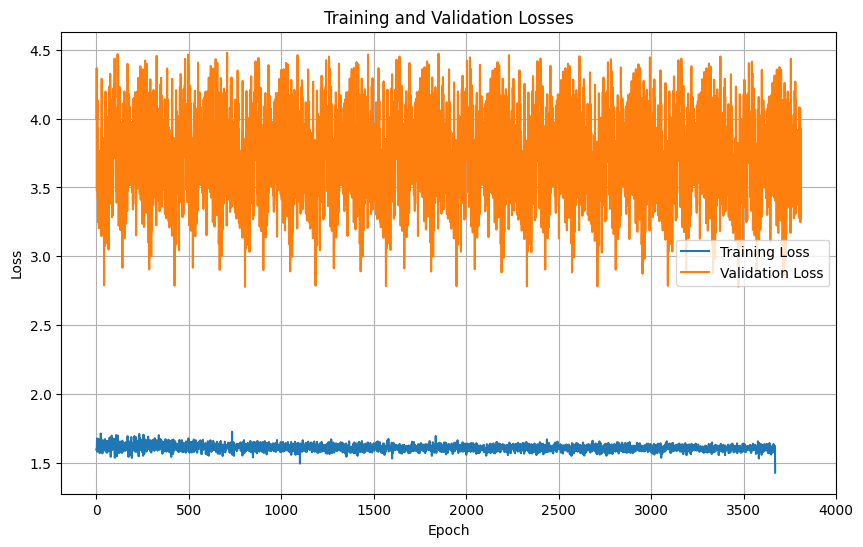


Training Summary:
Initial Training Loss: 1.5966
Final Training Loss: 1.4294
Best Training Loss: 1.4294

Initial Validation Loss: 3.9964
Final Validation Loss: 3.4979
Best Validation Loss: 2.7779


In [27]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

In [28]:
df_validation

shape: (12_176, 6)
┌─────────┬───────────────────┬───────────────────┬──────────────────┬───────────────┬─────────────┐
│ user_id ┆ article_id_fixed  ┆ article_ids_invie ┆ article_ids_clic ┆ impression_id ┆ labels      │
│ ---     ┆ ---               ┆ w                 ┆ ked              ┆ ---           ┆ ---         │
│ i64     ┆ list[i64]         ┆ ---               ┆ ---              ┆ i64           ┆ list[i64]   │
│         ┆                   ┆ list[i64]         ┆ list[i64]        ┆               ┆             │
╞═════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════╪═════════════╡
│ 1998759 ┆ [9780019,         ┆ [9789386,         ┆ [9788024]        ┆ 479058116     ┆ [0, 0, … 1] │
│         ┆ 9779648, …        ┆ 9787722, …        ┆                  ┆               ┆             │
│         ┆ 9779430]          ┆ 9788024]          ┆                  ┆               ┆             │
│ 1383295 ┆ [9777822,         ┆ [9779427,         ┆ [9779417]        ┆ 349219117     ┆ [0, 0, … 0] │
│         ┆ 9779511, …        ┆ 9366571, …        ┆                  ┆               ┆             │
│         ┆ 9779517]          ┆ 9779564]          ┆                  ┆               ┆             │
│ 2419726 ┆ [9776190,         ┆ [9773727,         ┆ [9773727]        ┆ 119537592     ┆ [1, 0, … 0] │
│         ┆ 9777565, …        ┆ 9783164, …        ┆                  ┆               ┆             │
│         ┆ 9776337]          ┆ 9781360]          ┆                  ┆               ┆             │
│ 823326  ┆ [9778102,         ┆ [9786111,         ┆ [9785019]        ┆ 214086519     ┆ [0, 0, … 0] │
│         ┆ 9777750, …        ┆ 9784097, …        ┆                  ┆               ┆             │
│         ┆ 9778168]          ┆ 9782769]          ┆                  ┆               ┆             │
│ 806990  ┆ [9776223,         ┆ [9779650,         ┆ [9781502]        ┆ 386289507     ┆ [0, 0, … 1] │
│         ┆ 9778971, …        ┆ 9532638, …        ┆                  ┆               ┆             │
│         ┆ 9780181]          ┆ 9781502]          ┆                  ┆               ┆             │
│ …       ┆ …                 ┆ …                 ┆ …                ┆ …             ┆ …           │
│ 1701495 ┆ [9778657,         ┆ [9785828,         ┆ [9780439]        ┆ 461263394     ┆ [0, 0, … 0] │
│         ┆ 9777492, …        ┆ 9782763, …        ┆                  ┆               ┆             │
│         ┆ 9779996]          ┆ 9785680]          ┆                  ┆               ┆             │
│ 1659077 ┆ [9766011,         ┆ [9785016,         ┆ [9786763]        ┆ 228172933     ┆ [0, 0, … 0] │
│         ┆ 9766805, …        ┆ 9777950, …        ┆                  ┆               ┆             │
│         ┆ 9776438]          ┆ 9787336]          ┆                  ┆               ┆             │
│ 137738  ┆ [9775881,         ┆ [9785718,         ┆ [9781316]        ┆ 184243668     ┆ [0, 0, … 0] │
│         ┆ 9775713, …        ┆ 9455386, …        ┆                  ┆               ┆             │
│         ┆ 9779489]          ┆ 9782808]          ┆                  ┆               ┆             │
│ 952409  ┆ [9778666,         ┆ [9484153,         ┆ [9787931]        ┆ 398885668     ┆ [0, 0, … 0] │
│         ┆ 9778623, …        ┆ 9786557, …        ┆                  ┆               ┆             │
│         ┆ 9778666]          ┆ 9780702]          ┆                  ┆               ┆             │
│ 1610738 ┆ [9779738,         ┆ [9781763,         ┆ [9781763]        ┆ 292204879     ┆ [1, 0, … 0] │
│         ┆ 9779674, …        ┆ 9783334, …        ┆                  ┆               ┆             │
│         ┆ 9777182]          ┆ 9782074]          ┆                  ┆               ┆             │
└─────────┴───────────────────┴───────────────────┴──────────────────┴───────────────┴─────────────┘

## Evaluate the model

In [29]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

# Initialize lists
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for (his_input_title, pred_input_title), targets in val_dataloader:
        # Move to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        targets = targets.to(device)
        
        # Get predictions
        predictions = model.predict(his_input_title, pred_input_title)
        
        # Convert to probabilities if needed
        if not torch.is_floating_point(predictions):
            predictions = torch.sigmoid(predictions)
        
        # Convert to lists while preserving structure
        batch_preds = predictions.cpu().numpy().tolist()
        batch_labels = targets.cpu().numpy().tolist()
        
        # Add batch predictions and labels
        all_predictions.extend(batch_preds)
        all_labels.extend(batch_labels)



In [30]:
print(type(all_predictions))
print(type(all_labels))

print(f"Number of predictions: {len(all_predictions)}")
print(f"example prediction: {all_predictions[0:2]}")
print(f"Number of labels: {len(all_labels)}")
print(f"example label: {all_labels[0:2]}")

<class 'list'>
<class 'list'>
Number of predictions: 12176
example prediction: [[0.4966225326061249, 0.5013707280158997, 0.4946349561214447, 0.4798656404018402, 0.5126184821128845, 0.49451765418052673, 0.513298749923706, 0.5059490203857422, 0.5087880492210388, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49114206433296204, 0.49

In [31]:
from evaluation import AucScore

# auc_score = AucScore()

# auc_score.calculate(all_predictions, all_labels)
# print(f"AUC: {auc_score.score}")
# # Calculate AUC per sample
aucs = []
for preds, labels in zip(all_predictions, all_labels):
    try:
        # Only calculate if we have both positive and negative samples
        if sum(labels) > 0 and sum(labels) < len(labels):
            auc = roc_auc_score(labels, preds)
            aucs.append(auc)
    except ValueError:
        raise ValueError("Only one class present in labels. Cannot calculate AUC.")

print(f"\nMean AUC: {np.mean(aucs):.4f}")
print(f"Number of valid AUC calculations: {len(aucs)}")


Mean AUC: 0.6877
Number of valid AUC calculations: 12176


In [32]:
def calculate_recommender_auc(preds, labels):
    # Ensure labels are at least 1-dimensional
    labels = np.atleast_1d(labels)
    
    # Get positive/negative indices
    pos_idx = np.where(labels == 1)[0]
    neg_idx = np.where(labels == 0)[0]
    
    if len(pos_idx) == 0 or len(neg_idx) == 0:
        return 0.0
        
    # Get predictions
    pos_preds = np.array(preds)[pos_idx]
    neg_preds = np.array(preds)[neg_idx]
    
    # Vectorized comparison
    correct_pairs = sum((p_i > neg_preds.reshape(1, -1)).sum() 
                        for p_i in pos_preds)
    
    # Paper's formula
    auc = correct_pairs / (len(pos_idx) * len(neg_idx))
    
    return float(auc)

# Calculate AUCs
aucs = []
for preds, labels in zip(all_predictions, all_labels):
    auc = calculate_recommender_auc(preds, labels)
    if auc > 0:
        aucs.append(auc)

mean_auc = np.mean(aucs) if aucs else 0.0
print(f"\nMean AUC: {mean_auc:.4f}")


Mean AUC: 0.7631


In [33]:
# Assuming val_dataloader is an iterable that yields (his_input_title, pred_input_title) tuples
pred_scores = []
pred_labels = []
counter = 0
with torch.no_grad():
    for (his_input_title, pred_input_title), targets in val_dataloader:
        # print(f"targets shape: {targets.shape} {targets[1]}")
       # print(f"his_input_title shape: {his_input_title.shape}")
       # print(f"pred_input_title shape: {pred_input_title.shape}")
        
        # Predict scores
        pred_scores.extend(model.predict(his_input_title, pred_input_title).tolist())
        pred_labels.extend(targets.cpu().numpy())
        # print(f"pred_scores: {pred_scores}")
        # print(f"pred_labels: {pred_labels}")
        
     #   print(f"pred_scores shape: {pred_scores.shape} {pred_scores}")
        # index number of maximum value in pred_scores
       # pred_scores_index = torch.argmax(pred_scores, dim=1)
        counter += 1
        # print(counter)
        # Append predictions grouped by user
       # pred_validation.append(pred_scores)  # Keep as 2D list


# print(f"Number of predictions: {len(pred_scores)} {pred_scores}")
# print(f"Number of articles: {len(pred_scores[0])} ")

# Find the index of the maximum score for each user
max_indexes = []
for i, scores in enumerate(pred_scores):
    max = -1
    max_index = -1
    for j, score in enumerate(scores):
        if score > max:
            max = score
            max_index = j
    max_indexes.append(max_index)

# create a list of lists with 1 at the index of the max score and 0 elsewhere
prediction_clean = []
labels : list = df_validation["labels"].to_list()
for i, score_index in enumerate(max_indexes):
    single_score = []
    for j, label in enumerate(labels[i]):
        if j == score_index:
            single_score.append(1)
        else:
            single_score.append(0)
    prediction_clean.append(single_score)
            
 

    
# print(f"preidciton :   {prediction_clean}")
# print(f"df_validation: {df_validation["labels"].to_list()}")

# Flatten predictions for DataFrame alignment
#flat_pred_validation = [score for user_scores in pred_validation for score in user_scores]
#print(f"Number of flattened predictions: {len(flat_pred_validation)} {flat_pred_validation}")
# Add predictions to dataframe
# Ensure pred_scores length matches df_validation length
if len(pred_scores) != len(df_validation):
    raise ValueError(f"Length of pred_scores ({len(pred_scores)}) does not match number of rows in df_validation ({len(df_validation)})")

# for row in df_validation.iter_rows(named=True):
#     row["scores"] = pred_scores[idx]

#df_validation["scores"] = df_validation["labels"].apply(lambda x: pred_scores.pop(0))

# df_validation = add_prediction_scores(df_validation, pred_scores).pipe(
#     add_known_user_column, known_users=df_train[DEFAULT_USER_COL]
# )

# print(f"{len(df_validation["labels"].to_list())} {len(pred_scores)}")
# print(f"df_validation: {df_validation["labels"].to_list()}")
# print(f"pred_scores:   {pred_scores}")

# for i, scores in enumerate(prediction_clean):
#     print(f"{len(scores)} {len(df_validation['labels'].to_list()[i])}" )

# Compute metrics
metrics = MetricEvaluator(
    labels=df_validation["labels"].to_list(),
    predictions=prediction_clean,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)

c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\models_pytorch\NRMSDocVecModel.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Metrics: {'auc': 0.5025781175869883, 'mrr': 0.31605217647066497, 'ndcg@5': 0.347070638464702, 'ndcg@10': 0.4315409160553232}


In [34]:
for i, scores in enumerate(prediction_clean):
    print(i)
    print(f"{len(scores)} {len(df_train['labels'].to_list()[i])}" )

0
9 5
1
23 5
2
5 5
3
54 5
4
10 5
5
6 5
6
11 5
7
25 5
8
11 5
9
5 5
10
15 5
11
5 5
12
10 5
13
10 5
14
9 5
15
6 5
16
23 5
17
25 5
18
14 5
19
33 5
20
7 5
21
9 5
22
7 5
23
6 5
24
6 5
25
5 5
26
10 5
27
16 5
28
6 5
29
6 5
30
19 5
31
6 5
32
11 5
33
6 5
34
39 5
35
8 5
36
17 5
37
5 5
38
9 5
39
6 5
40
6 5
41
7 5
42
8 5
43
11 5
44
13 5
45
8 5
46
16 5
47
8 5
48
79 5
49
30 5
50
5 5
51
12 5
52
7 5
53
6 5
54
5 5
55
17 5
56
8 5
57
13 5
58
15 5
59
7 5
60
13 5
61
18 5
62
11 5
63
7 5
64
8 5
65
15 5
66
8 5
67
5 5
68
6 5
69
6 5
70
5 5
71
11 5
72
5 5
73
26 5
74
8 5
75
6 5
76
8 5
77
22 5
78
5 5
79
6 5
80
8 5
81
25 5
82
32 5
83
14 5
84
5 5
85
22 5
86
13 5
87
6 5
88
6 5
89
10 5
90
9 5
91
6 5
92
12 5
93
29 5
94
5 5
95
9 5
96
6 5
97
11 5
98
13 5
99
23 5
100
6 5
101
9 5
102
11 5
103
22 5
104
9 5
105
58 5
106
15 5
107
33 5
108
7 5
109
11 5
110
7 5
111
19 5
112
16 5
113
5 5
114
24 5
115
18 5
116
13 5
117
6 5
118
8 5
119
7 5
120
12 5
121
6 5
122
12 5
123
8 5
124
9 5
125
8 5
126
16 5
127
13 5
128
6 5
129
6 5
130
5 5
1

IndexError: list index out of range

## Output Prediction File

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb